In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
class DelayAnalysis:

    def __init__(self, folder, file):
        self.raw_data = self.read_out_tr(folder, file)
        self.tcp_pkt = self.get_tcp_packets(self.raw_data)
        history = self.tcp_pkt.groupby('pkt_id')
        self.duration = (history['time'].last() - history['time'].first()) * 1e6
        
    def read_out_tr(self, dir, file):
        col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
        df = pd.read_csv(dir+file, sep = ' ', header = None)
        df.columns = col
        return df
    
    def get_tcp_packets(self, df):
        df_out = df.loc[df["pkt_type"].isin(["tcp"])]
        return df_out
    
    def get_pkt_detail_by_pktid(self, id):
        return self.tcp_pkt[self.tcp_pkt['pkt_id'] == id]
    
    def dropped_pkt_and_id(self):
        history = self.tcp_pkt.groupby('pkt_id')
        dropped_pkt_id = (history['events'].last() == 'd')
        dropped_pkt_id = dropped_pkt_id[dropped_pkt_id]
        dropped = self.tcp_pkt[self.tcp_pkt.pkt_id.isin(dropped_pkt_id.index)]
        dropped.set_index(['pkt_id', dropped.index], inplace = True)
        return dropped, dropped_pkt_id.index.tolist()
    
    def print_pkt_delay(self, rtt):
        # us
        duration = self.duration
        drop_id = self.dropped_pkt_and_id()[1]
        #plt.figure(figsize=(20, 8))
        plt.scatter(duration.index, duration, label='received')
        plt.xlabel('pkt_id')
        plt.ylabel('delay(ms)')
        plt.axhline(y=rtt/2, color='g', linestyle='-')
        plt.scatter(duration[drop_id].index, duration[drop_id], color='r', label='drop')
        plt.legend()
        
    def filter_by_delay(self, boolFunc):
        duration = self.duration
        filter_pkt = self.tcp_pkt[self.tcp_pkt.pkt_id.isin(duration[boolFunc].index)]
        filter_pkt.set_index(['pkt_id', filter_pkt.index], inplace = True)
        return filter_pkt

In [3]:
AFQ10folder = "/home/ovs2/lining/Gearbox/manual/AFQ10/"
AFQ10delay = DelayAnalysis(AFQ10folder, 'out.tr')
HRCCfolder = "/home/ovs2/lining/Gearbox/manual/HRCC/"
HRCCdelay = DelayAnalysis(HRCCfolder, 'out.tr')

In [4]:
drop_pkt, drop_pkt_id = AFQ10delay.dropped_pkt_and_id()
print(drop_pkt_id[:10], '...')
drop_pkt.head()

[1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003] ...


events      time  from_node  to_node pkt_type  pkt_size    flags  \
pkt_id                                                                         
1976   9212      +  1.005701         23       13      tcp      1500  ------N   
       9225      -  1.005702         23       13      tcp      1500  ------N   
1979   9255      +  1.005702         23       13      tcp      1500  ------N   
       9268      -  1.005702         23       13      tcp      1500  ------N   
1982   9300      +  1.005702         23       13      tcp      1500  ------N   

             fid  src_addr  dst_addr  seq_num  
pkt_id                                         
1976   9212    7      23.0      35.3   224841  
       9225    7      23.0      35.3   224841  
1979   9255    7      23.0      35.3   227761  
       9268    7      23.0      35.3   227761  
1982   9300    7      23.0      35.3   230681

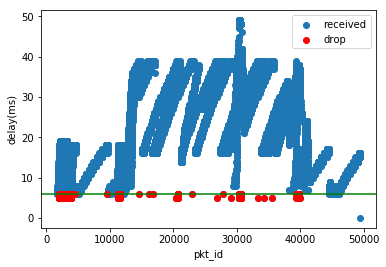

In [5]:
AFQ10delay.print_pkt_delay(12)

### <span style="color:red"> here is a problem, boundary is also included</span>.

In [6]:
# below 6 ms
res = AFQ10delay.filter_by_delay(lambda delay: (10 < delay) & (delay < 12))
res.head()

events      time  from_node  to_node pkt_type  pkt_size    flags  \
pkt_id                                                                         
1800   6369      +  1.005674         23       13      tcp      1500  ------N   
       6376      -  1.005674         23       13      tcp      1500  ------N   
1801   6390      +  1.005674         23       13      tcp      1500  ------N   
       6391      -  1.005674         23       13      tcp      1500  ------N   
1802   6392      +  1.005674         23       13      tcp      1500  ------N   

             fid  src_addr  dst_addr  seq_num  
pkt_id                                         
1800   6369    7      23.0      35.3    70081  
       6376    7      23.0      35.3    70081  
1801   6390    7      23.0      35.3    71541  
       6391    7      23.0      35.3    71541  
1802   6392    7      23.0      35.3    73001

In [7]:
AFQ10delay.get_pkt_detail_by_pktid(1800)

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id
6369,+,1.005674,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6376,-,1.005674,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6459,r,1.005675,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6460,+,1.005675,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6461,-,1.005675,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6550,r,1.005676,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6551,+,1.005676,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6552,-,1.005676,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6645,r,1.005678,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6646,+,1.005678,10,7,tcp,1500,------N,7,23.0,35.3,70081,1800
